<a href="https://colab.research.google.com/github/sebavassou/CatsandDogsModelTransferLearning/blob/main/CatsandDogsModelTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visão Geral do Projeto
O objetivo é aplicar Transfer Learning em uma rede neural profunda usando Python no ambiente Google Colab. O projeto se baseará no exemplo do MNIST, mas será adaptado para classificar imagens de gatos e cachorros.
Dataset Cats vs Dogs
O dataset "Cats vs Dogs" é uma coleção extensa de imagens de gatos e cachorros, ideal para tarefas de classificação binária2. Algumas características importantes do dataset incluem:
•	Tamanho total: 1.04 GiB
•	Número de exemplos: 23,262 imagens no conjunto de treinamento
•	Formato das imagens: RGB (3 canais de cor)
•	Classes: 2 (gato e cachorro)
É importante notar que o dataset original continha algumas imagens corrompidas, mas essas foram removidas na versão atual2.
Implementação do Transfer Learning
Para implementar o Transfer Learning, seguimos estas ações:
1.	Carregar o dataset: Use a API do TensorFlow Datasets para carregar os dados:

import tensorflow_datasets as tfds

dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

2.	Pré-processar as imagens: Redimensione e normalize as imagens para se adequarem ao modelo pré-treinado que você escolher.

3.	Escolher um modelo base: Selecione um modelo pré-treinado, como VGG16, ResNet50 ou InceptionV3, disponível no Keras.

4.	Congelar as camadas base: Para preservar os pesos pré-treinados:
python

base_model.trainable = False

5.	Adicionar novas camadas: Adicione camadas densas no topo do modelo base para a classificação específica de gatos e cachorros.

6.	Compilar e treinar: Compile o modelo com um otimizador adequado e treine-o com os dados de gatos e cachorros.

7.	Fine-tuning: Opcionalmente, descongele algumas camadas superiores do modelo base e faça um fine-tuning com uma taxa de aprendizado baixa.

Considerações Adicionais:

•	O dataset está disponível para download direto da Microsoft, com um tamanho de 786.7 MB
•	Utilizamos o Google Colab para aproveitar os recursos de GPU gratuitos, o que pode acelerar significativamente o treinamento do modelo.
•	Consideramos usar técnicas de aumento de dados (data augmentation) para melhorar a generalização do modelo, especialmente considerando o número relativamente pequeno de imagens no dataset.



In [2]:
# Importando as bibliotecas necessárias
#import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#from tensorflow.keras.models import Model
#import matplotlib.pyplot as plt
#import os
#from PIL import UnidentifiedImageError

In [15]:
!pip install pillow_heif

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
from PIL import Image, UnidentifiedImageError
import pillow_heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.2 MB/s eta 0:00:00


In [16]:
# Configurando o TensorFlow para usar GPU, se disponível
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [17]:
# Definindo parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [18]:
# Baixando e extraindo o dataset
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zipAa
!unzip -q kagglecatsanddogs_5340.zip


--2025-02-18 17:28:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zipAa
Resolving download.microsoft.com (download.microsoft.com)... 184.29.22.44, 2600:1406:bc00:a81::317f, 2600:1406:bc00:a8e::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.29.22.44|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-18 17:28:46 ERROR 404: Not Found.

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [19]:
# Preparando os geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'PetImages',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'PetImages',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [20]:
# Carregando o modelo base VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


In [21]:
# Adicionando novas camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [22]:
# Compilando o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Function to handle image loading errors
def load_image_with_error_handling(img_path):
    try:
        # Attempt to open the image using Pillow
        img = Image.open(img_path)
        # Convert HEIC images to RGB if needed
        if img.format == "HEIF":
            img = img.convert("RGB")
        # Resize and convert to array
        img = img.resize(IMG_SIZE)
        img = tf.keras.utils.img_to_array(img)
        return img
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error loading image {img_path}: {e}")
        return None

In [24]:
# Custom generator with error handling
def data_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        # Filter out images that couldn't be loaded
        valid_indices = [i for i, img in enumerate(batch_x) if img is not None]
        if valid_indices:
            yield batch_x[valid_indices], batch_y[valid_indices]
        else:
            # If all images in the batch are invalid, skip the batch
            continue

In [25]:
# Create custom generators for training and validation
train_generator_wrapped = data_generator(train_generator)
validation_generator_wrapped = data_generator(validation_generator)


In [26]:
# Treinando o modelo
# Now use the wrapped generators
history = model.fit(
    train_generator_wrapped,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator_wrapped,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/10
173/625 ━━━━━━━━━━━━━━━━━━━━ 3:13 428ms/step - accuracy: 0.7403 - loss: 0.5259

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


293/625 ━━━━━━━━━━━━━━━━━━━━ 2:22 428ms/step - accuracy: 0.7738 - loss: 0.4752

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e4b4fd664d0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator():

  File "<ipython-input-24-e99e7bdded74>", line 4, in data_generator
    batch_x, batch_y = next(generator)
                       ^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 112, in __next__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/PIL/Image.py", line 3532, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e4b4fd664d0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) UNKNOWN:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e4b4fd664d0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator():

  File "<ipython-input-24-e99e7bdded74>", line 4, in data_generator
    batch_x, batch_y = next(generator)
                       ^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 112, in __next__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/PIL/Image.py", line 3532, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e4b4fd664d0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_16917]

NameError: name 'history' is not defined

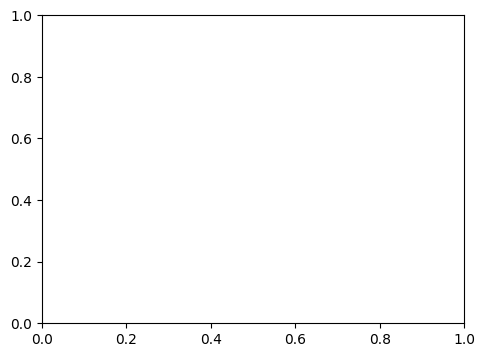

In [14]:
# Plotando os resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fine-tuning (opcional)
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5
)


In [ ]:
# Salvando o modelo
model.save('cats_vs_dogs_model.h5')
